In [10]:
import duckdb
import pandas as pd

# Load CSVs into DuckDB (paths are raw strings to avoid unicodeescape issues)
movies_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\movies.csv'
ratings_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\ratings.csv'
duckdb.sql(f"CREATE OR REPLACE TABLE movies AS SELECT * FROM read_csv_auto('{movies_path}')")
duckdb.sql(f"CREATE OR REPLACE TABLE ratings AS SELECT * FROM read_csv_auto('{ratings_path}')")
print('movies rows:', duckdb.sql('SELECT COUNT(*) FROM movies').fetchall())
print('ratings rows:', duckdb.sql('SELECT COUNT(*) FROM ratings').fetchall())



movies rows: [(9742,)]
ratings rows: [(100836,)]


In [11]:
# 1) Movie genres (unique)
genres_df = duckdb.sql("SELECT movieId, title, genres FROM movies").to_df()
genres_exploded = genres_df.assign(genres=genres_df.genres.str.split('|')).explode('genres')
unique_genres = sorted(genres_exploded['genres'].dropna().unique())
print('Movie genres (unique):')
print(unique_genres)

Movie genres (unique):
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [12]:
# 2) Number of movies per genre
movies_per_genre = genres_exploded.groupby('genres').movieId.nunique().reset_index(name='movie_count').sort_values('movie_count', ascending=False)
print('Number of movies per genre:')
print(movies_per_genre)

Number of movies per genre:
                genres  movie_count
8                Drama         4361
5               Comedy         3756
17            Thriller         1894
1               Action         1828
15             Romance         1596
2            Adventure         1263
6                Crime         1199
16              Sci-Fi          980
11              Horror          978
9              Fantasy          779
4             Children          664
3            Animation          611
14             Mystery          573
7          Documentary          440
18                 War          382
13             Musical          334
19             Western          167
12                IMAX          158
10           Film-Noir           87
0   (no genres listed)           34


In [13]:
# 3) Movie rating distribution per user (summary stats)
ratings_df = duckdb.sql("SELECT userId, movieId, rating, timestamp FROM ratings").to_df()
user_rating_counts = ratings_df.groupby('userId').rating.agg(['count','mean','std','min','max']).reset_index().rename(columns={'count':'ratings_count','mean':'ratings_mean','std':'ratings_std','min':'ratings_min','max':'ratings_max'})
print('Per-user rating distribution summary (first 10 users):')
print(user_rating_counts.head(10))
ratings_count_dist = user_rating_counts.ratings_count.value_counts().sort_index()
print('Distribution of number of ratings per user (ratings_count -> number of users):')
print(ratings_count_dist.head(20))

Per-user rating distribution summary (first 10 users):
   userId  ratings_count  ratings_mean  ratings_std  ratings_min  ratings_max
0       1            232      4.366379     0.800048          1.0          5.0
1       2             29      3.948276     0.805615          2.0          5.0
2       3             39      2.435897     2.090642          0.5          5.0
3       4            216      3.555556     1.314204          1.0          5.0
4       5             44      3.636364     0.990441          1.0          5.0
5       6            314      3.493631     0.850648          1.0          5.0
6       7            152      3.230263     1.329594          0.5          5.0
7       8             47      3.574468     0.972328          1.0          5.0
8       9             46      3.260870     1.272526          1.0          5.0
9      10            140      3.278571     1.175700          0.5          5.0
Distribution of number of ratings per user (ratings_count -> number of users):
ratings_

In [14]:
# 4) Movies with the highest average rating (with minimum number of ratings)
movie_stats = ratings_df.groupby('movieId').rating.agg(['mean','count']).reset_index().rename(columns={'mean':'avg_rating','count':'rating_count'})
movies_with_stats = movie_stats.merge(genres_df[['movieId','title']], on='movieId', how='left')
min_ratings = 50
top_movies = movies_with_stats[movies_with_stats.rating_count >= min_ratings].sort_values(['avg_rating','rating_count'], ascending=[False,False]).head(20)
print(f'\nTop movies by average rating (min {min_ratings} ratings):')
print(top_movies[['movieId','title','avg_rating','rating_count']])


Top movies by average rating (min 50 ratings):
      movieId                                              title  avg_rating  \
277       318                   Shawshank Redemption, The (1994)    4.429022   
659       858                              Godfather, The (1972)    4.289062   
2224     2959                                  Fight Club (1999)    4.272936   
974      1276                              Cool Hand Luke (1967)    4.271930   
602       750  Dr. Strangelove or: How I Learned to Stop Worr...    4.268041   
686       904                                 Rear Window (1954)    4.261905   
921      1221                     Godfather: Part II, The (1974)    4.259690   
6298    48516                               Departed, The (2006)    4.252336   
913      1213                                  Goodfellas (1990)    4.250000   
694       912                                  Casablanca (1942)    4.240000   
6693    58559                            Dark Knight, The (2008)    4.23


Top 10 most active users (userId -> ratings_count):
 userId  ratings_count
    414           2698
    599           2478
    474           2108
    448           1864
    274           1346
    610           1302
     68           1260
    380           1218
    606           1115
    288           1055


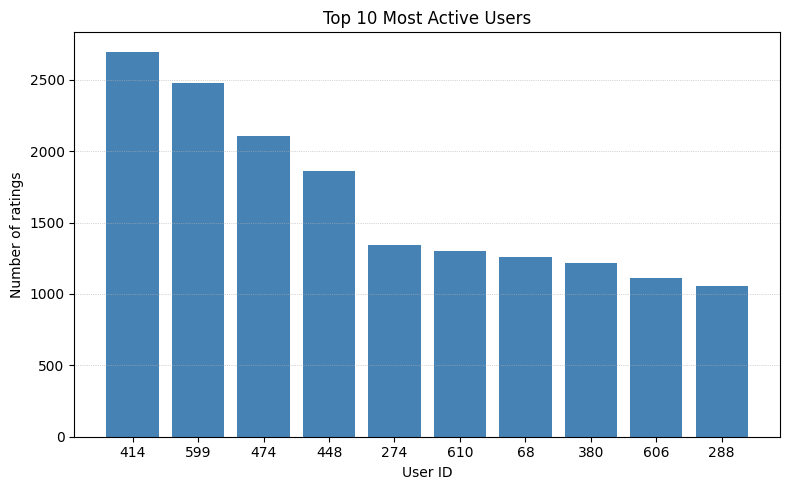

In [ ]:
# ----------------------------
# 1) Most active users
# ----------------------------
most_active = (
    ratings_df.groupby('userId')['rating']
    .count()
    .reset_index(name='ratings_count')
    .sort_values('ratings_count', ascending=False)
)
print("\nTop 10 most active users (userId -> ratings_count):")
print(most_active.head(10).to_string(index=False))

# Take top 10 most active users
top10_users = most_active.head(10)

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(top10_users['userId'].astype(str), top10_users['ratings_count'], color='steelblue')
plt.xlabel("User ID")
plt.ylabel("Number of ratings")
plt.title("Top 10 Most Active Users")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Pull tables to pandas
movies_df = duckdb.sql("SELECT * FROM movies").to_df()
ratings_df = duckdb.sql("SELECT * FROM ratings").to_df()

# Normalize column names in case (ml-latest-small uses movieId/userId)
# (your code used movieId/userId already — adapt if you have movie_id/user_id)
print("Loaded rows:", len(movies_df), "movies;", len(ratings_df), "ratings")

Loaded rows: 9742 movies; 100836 ratings


In [18]:
# explode genres (pandas)
genres_df = movies_df[['movieId', 'title', 'genres']].copy()
genres_df['genres_list'] = genres_df['genres'].str.split('|')
genres_exploded = genres_df.explode('genres_list').rename(columns={'genres_list': 'genre'})
genres_exploded = genres_exploded[~genres_exploded['genre'].isna()].reset_index(drop=True)

# join ratings -> compute per-genre stats
ratings_with_genres = ratings_df.merge(genres_exploded[['movieId', 'genre']], on='movieId', how='left')
genre_stats = (
    ratings_with_genres.groupby('genre')['rating']
    .agg(['mean','count'])
    .rename(columns={'mean':'avg_rating','count':'rating_count'})
    .reset_index()
    .sort_values('avg_rating', ascending=False)
)
print("\nTop-rated genres (by average rating) — full table head:")
print(genre_stats.head(20).to_string(index=False))

# Optional: show only genres with a minimum number of ratings for stability:
min_ratings_genre = 1000
stable_genres = genre_stats[genre_stats['rating_count'] >= min_ratings_genre].sort_values('avg_rating', ascending=False)
print(f"\nGenres with >= {min_ratings_genre} ratings (stable):")
print(stable_genres.to_string(index=False))


Top-rated genres (by average rating) — full table head:
             genre  avg_rating  rating_count
         Film-Noir    3.920115           870
               War    3.808294          4859
       Documentary    3.797785          1219
             Crime    3.658294         16681
             Drama    3.656184         41928
           Mystery    3.632460          7674
         Animation    3.629937          6988
              IMAX    3.618335          4145
           Western    3.583938          1930
           Musical    3.563678          4138
         Adventure    3.508609         24161
           Romance    3.506511         18124
          Thriller    3.493706         26452
           Fantasy    3.491001         11834
(no genres listed)    3.489362            47
            Sci-Fi    3.455721         17243
            Action    3.447984         30635
          Children    3.412956          9208
            Comedy    3.384721         39053
            Horror    3.258195          729

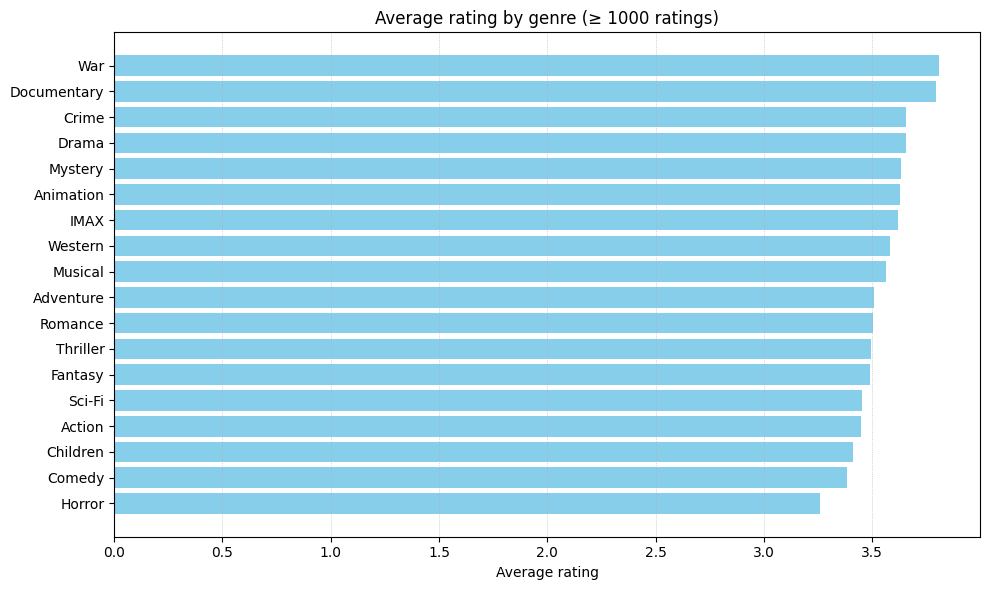

In [25]:
import matplotlib.pyplot as plt

# Bar chart of stable genres by average rating
plt.figure(figsize=(10,6))
plt.barh(stable_genres['genre'], stable_genres['avg_rating'], color='skyblue')
plt.xlabel("Average rating")
plt.title(f"Average rating by genre (≥ {min_ratings_genre} ratings)")
plt.gca().invert_yaxis()  # highest rating at top
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

How have average movie ratings and rating activity evolved over time in the MovieLens dataset?


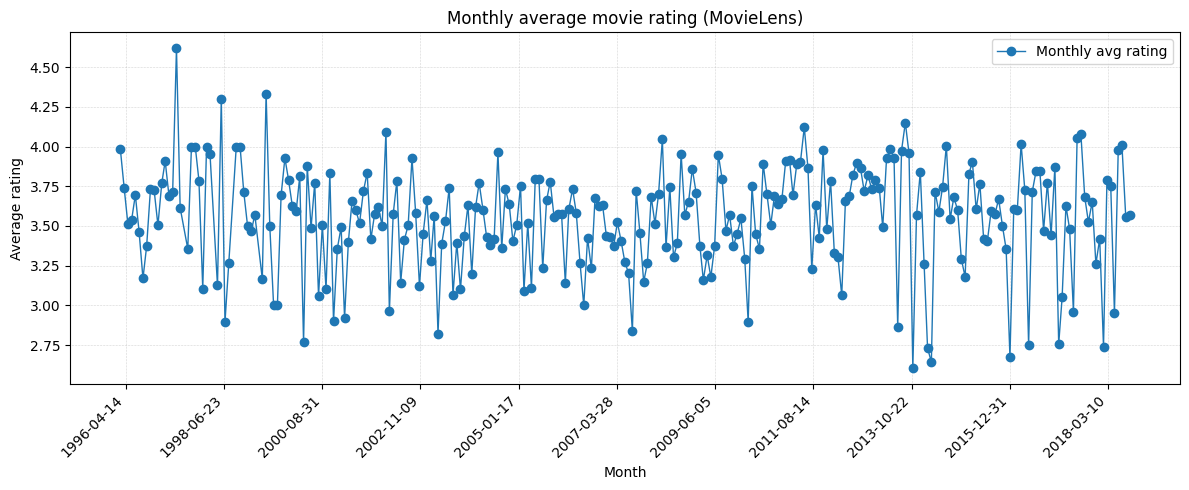

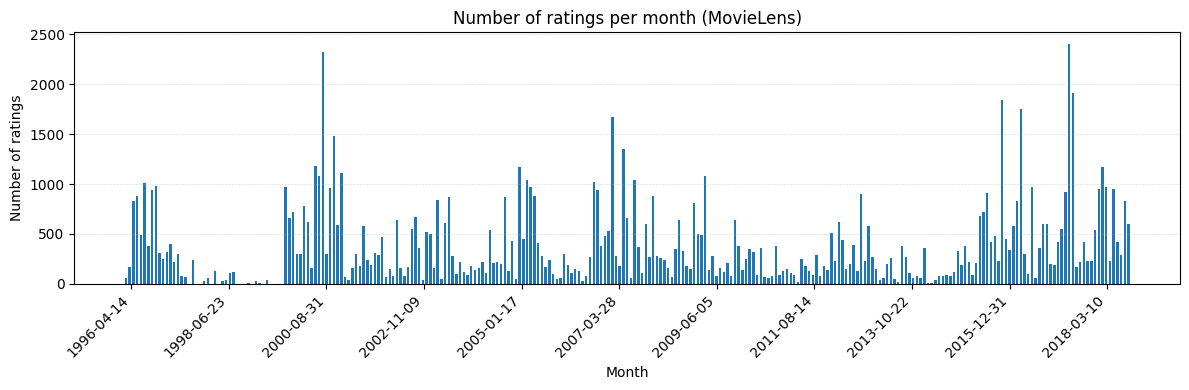


Recent monthly averages (last 12 months available in data):
month_start  avg_rating  rating_count  avg_rating_3m
 2017-10-01    3.524444           225       3.619800
 2017-11-01    3.652174           230       3.479271
 2017-12-01    3.261194           536       3.444281
 2018-01-01    3.419474           950       3.139778
 2018-02-01    2.738666          1169       3.314986
 2018-03-01    3.786818           971       3.425161
 2018-04-01    3.750000           230       3.496149
 2018-05-01    2.951630           951       3.560448
 2018-06-01    3.979714           419       3.647194
 2018-07-01    4.010239           293       3.849238
 2018-08-01    3.557762           831       3.712236
 2018-09-01    3.568709           604       3.563235


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
# ---- Prepare time columns ----
# MovieLens timestamps are unix seconds
ratings_df['ts'] = pd.to_datetime(ratings_df['timestamp'], unit='s', errors='coerce')
# Drop any rows with bad timestamps (safety)
ratings_df = ratings_df.dropna(subset=['ts']).copy()

# Year-month string (easier to display) and an actual month-start datetime for plotting
ratings_df['year_month'] = ratings_df['ts'].dt.to_period('M').astype(str)
ratings_df['month_start'] = ratings_df['ts'].values.astype('datetime64[M]')  # first day of month

# ---- Aggregate: monthly mean rating and count ----
time_trend = (
    ratings_df
    .groupby('month_start')['rating']
    .agg(avg_rating='mean', rating_count='count')
    .reset_index()
    .sort_values('month_start')
)

# Optional: add a rolling average of avg_rating to smooth short-term noise (3-month window)
time_trend['avg_rating_3m'] = time_trend['avg_rating'].rolling(window=3, min_periods=1, center=True).mean()

# ---- Plot 1: Monthly average rating (line only, no rolling average) ----
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(
    time_trend['month_start'],
    time_trend['avg_rating'],
    marker='o',
    linewidth=1,
    label='Monthly avg rating'
)
ax1.set_title('Monthly average movie rating (MovieLens)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average rating')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=12))  # keep x-axis reasonably spaced
plt.xticks(rotation=45, ha='right')
ax1.grid(True, linestyle=':', linewidth=0.4)
ax1.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Monthly rating counts (bar) ----
fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.bar(time_trend['month_start'], time_trend['rating_count'], width=20)  # width in days approx
ax2.set_title('Number of ratings per month (MovieLens)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of ratings')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45, ha='right')
ax2.grid(axis='y', linestyle=':', linewidth=0.4)
plt.tight_layout()
plt.show()

# ---- Quick textual summary printed for context ----
print("\nRecent monthly averages (last 12 months available in data):")
print(time_trend.tail(12).to_string(index=False))


In [20]:
# ----------------------------
# 4) Which movies have the most ratings?
# ----------------------------
movie_stats = (
    ratings_df.groupby('movieId')['rating']
    .agg(['mean','count'])
    .rename(columns={'mean':'avg_rating','count':'rating_count'})
    .reset_index()
)
movies_with_stats = movie_stats.merge(movies_df[['movieId','title']], on='movieId', how='left')
top_by_count = movies_with_stats.sort_values('rating_count', ascending=False).head(20)
print("\nTop 10 movies by number of ratings (title -> count, avg_rating):")
print(top_by_count[['title','rating_count','avg_rating']].head(10).to_string(index=False))



Top 10 movies by number of ratings (title -> count, avg_rating):
                                    title  rating_count  avg_rating
                      Forrest Gump (1994)           329    4.164134
         Shawshank Redemption, The (1994)           317    4.429022
                      Pulp Fiction (1994)           307    4.197068
         Silence of the Lambs, The (1991)           279    4.161290
                       Matrix, The (1999)           278    4.192446
Star Wars: Episode IV - A New Hope (1977)           251    4.231076
                     Jurassic Park (1993)           238    3.750000
                        Braveheart (1995)           237    4.031646
        Terminator 2: Judgment Day (1991)           224    3.970982
                  Schindler's List (1993)           220    4.225000


In [21]:
# ----------------------------
# 5) Correlation between popularity and average rating
# ----------------------------
# Popularity measure = rating_count; compute Pearson correlation with avg_rating
corr = movies_with_stats['rating_count'].corr(movies_with_stats['avg_rating'])
print(f"\nPearson correlation between number of ratings and average rating: {corr:.4f}")

# Optionally compute correlation only for movies with >= N ratings (to avoid very-low-count noise)
min_ratings_for_corr = 30
subset = movies_with_stats[movies_with_stats['rating_count'] >= min_ratings_for_corr]
corr_stable = subset['rating_count'].corr(subset['avg_rating'])
print(f"Correlation (movies with >= {min_ratings_for_corr} ratings): {corr_stable:.4f}")



Pearson correlation between number of ratings and average rating: 0.1273
Correlation (movies with >= 30 ratings): 0.3180
